# Домашнее задание 1. Сбор данных

При решении реальных задач мы почти никогда не имеем дело с "хорошими" исходными данными, уже подготовленными для обработки и анализа. Как правило на входе имеются неструкткрированные данные в "грязном" виде, например необработанные тексты, изображения или аудио файлы. Иногда нет даже этого, и данные приходится собирать из разных доступных источников: разнообразных баз данных, внешних сервисов и даже электронных таблиц. После того, как данные получены, их унифицируют, очищают от шума, преобразовывают в нужный вид и сохраняют для дальнейшего анализа. В одном из традиционных подходов к [Data Mining](http://www.wikiwand.com/en/Online_analytical_processing) этот процесс называется Extract-Transform-Load ([ETL](http://www.wikiwand.com/en/Extract,_transform,_load)).

Цель этого задания собрать первые данные о пользователях из обучающей выборки и провести простейший качественный анализ. В ходе решения будут использованы:
1. [numpy](http://www.numpy.org/) -- библиотека для работы с многомерными массивами
2. [pandas](http://pandas.pydata.org/) -- библиотека, позволяющая удобно работать с различными типами данных
3. [requests](http://docs.python-requests.org/en/latest/) -- библиотека, которую можно использовать для вызова HTTP запросов
4. [python-twitter](https://github.com/bear/python-twitter/tree/master/twitter) -- обертка для Twitter API
5. [matplotlib](http://matplotlib.org/) -- библиотека для рисования графиков в python

Первым делом импортируем необходимые библиотеки и убеждаемся, что все установлено.

In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import mpl_toolkits.basemap as bm
import twitter
import requests
import datetime
import dateutil
import csv
import os
import json

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Чтение исходных данных из файла

Считываем исходные данные из файла в data frame библиотеки pandas. Полученный data frame должен иметь целочисленный ключ и две колонки:
1. uid -- идентификатор пользователя
2. cat -- числовой номер класса

In [2]:
TRAINING_SET_URL = "twitter_train.txt"
EXAMPLE_SET_URL = "twitter_example.txt"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0, names=["uid", "cat"])
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0, names=["uid", "cat"])
df_users_ex['cat'] = None
df_users = pd.concat([df_users_train, df_users_ex])
df_users.head()

,uid,cat
0,40585382,1
1,30005269,0
2,3314758074,0
3,14311688,0
4,110457801,0


Построим распределение целевой переменной. Требуется получить [barchart](http://www.wikiwand.com/en/Bar_chart), в котором высота столбика, соответствующего каждому из классов, пропорциональна количеству пользователей этого класса. По горизонтальной оси отложены классы (positive, negative), а по вертикальной -- количество пользователей.

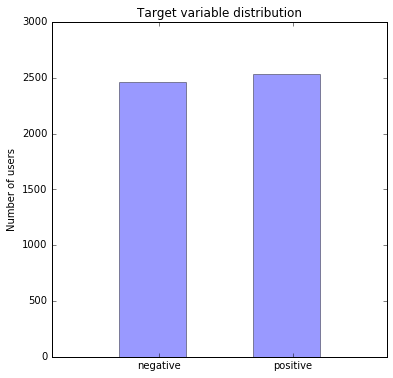

In [3]:
# Compute the distribution of the target variable
counts, bins = np.histogram(df_users_train["cat"], bins=[0,1,2])

# Plot the distribution
pl.figure(figsize=(6,6))
pl.bar(bins[:-1], counts, width=0.5, alpha=0.4)
pl.xticks(bins[:-1] + 0.3, ["negative", "positive"])
pl.xlim(bins[0] - 0.5, bins[-1])
pl.ylabel("Number of users")
pl.title("Target variable distribution")
pl.show()

## Сбор данных

Для того чтобы разработать модель, которая предсказывает значение целевой переменной для произвольного пользователя, недостаточно знать только значения идентификаторов пользоватей. Причина в том, что _user_id_ для пользователя никак не зависит от целевой переменной -- идентификатор генерируется на основании времени регистрации, сервера, обрабатывающего запрос, и номера пользователя ([подробности](https://dev.twitter.com/overview/api/twitter-ids-json-and-snowflake)).

Поэтому нам потребуется загрузить дополнительную информацию о каждом пользователе, иначе говоря провести сбор данных (data collection). Наиболее важную информацию можно загрузить из [Twitter](https://dev.twitter.com/rest/public) [API](http://www.wikiwand.com/en/Representational_state_transfer). При желании можно воспользоваться и другими источниками -- об этом ниже.

Для того, чтобы получить доступ к API прежде всего необходимо зарегистрироваться в Twitter в качестве разработчика и создать свое [приложение](https://apps.twitter.com/). После создания приложения будет доступен набор ключей, которые мы будем использовать для аутентификации. Эти ключи необходимо скопировать в соответствующие константы ниже. Подробнее о том, как работает аутентификация в Twitter API можно почитать [по ссылке](https://dev.twitter.com/oauth/application-only), хотя это нужно скорее для ознакомления: библиотека обращения с API позаботится о механизме аутентификации за нас.

In [4]:
CONSUMER_KEY = "YZYvBWBTTtv1hVY3nQO01Itg2"
CONSUMER_SECRET = "Ot4K9jeWcKHGfy8PT26M0evvi6FFYELEu70v7HuGUKOypcEtv2"

ACCESS_TOKEN_KEY = "703233869185728512-Eor7lD2e8rFhFPnFMum9q9loPvIywLS"
ACCESS_TOKEN_SECRET = "TuLDuiXvtjsCgC8NNE1vNBQP72Lt2Bh8ceh68FjcW5reh"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

Twitter API предоставляет информацию о местонахождении пользователя, но эта информация представлена в текстовом виде, например так:
```
"location": "San Francisco, CA"
```
Такие текстовый описания не слишком удобны для анализа, поэтому наша цель -- получить более структурированную информацию, такую как географические координаты, страна, город и т.д. Для этого удобно использовать геоинформационный сервис, например [GeoNames](http://www.geonames.org/export/web-services.html). Для его использования также необходимо зарегистрироваться, подтвердить регистрацию и включить поддержку API. После этого можно будет посылать запросы для нахождения нужной информации. Например на запрос
```
http://api.geonames.org/search?q="San Francisco, CA"&maxRows=10&username=demo
```
возвращается результат,
```javascript
{
    "totalResultsCount": 2112,
    "geonames": [
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "city, village,...",
            "countryCode": "US",
            "lng": "-122.41942",
            "fcodeName": "seat of a second-order administrative division",
            "toponymName": "San Francisco",
            "fcl": "P",
            "name": "San Francisco",
            "fcode": "PPLA2",
            "geonameId": 5391959,
            "lat": "37.77493",
            "adminName1": "California",
            "population": 805235
        },
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "spot, building, farm",
            "countryCode": "US",
            "lng": "-122.3758",
            "fcodeName": "airport",
            "toponymName": "San Francisco International Airport",
            "fcl": "S",
            "name": "San Francisco International Airport",
            "fcode": "AIRP",
            "geonameId": 5391989,
            "lat": "37.61882",
            "adminName1": "California",
            "population": 0
        }
    ]
}
```
из которого легко извлечь нужную информацию.

**Замечание: для запросов необходимо использовать своего пользователя, кроме того количество запросов ограничего 30к в день**.

Первым делом нам понадобится функция, которая возвращает информацию о местоположении для данного текстового запроса. Требуется реализовать функцию get_coordinates_by_location, принимающую на вход строку с местоположением и возвращает кортеж вида (долгота, широта, город).

In [8]:
GEO_USER_NAME = "vadimnavr"

def get_coordinates_by_location(location):  
    url = 'http://api.geonames.org/searchJSON?q='+location+'&maxRows=1&username='+GEO_USER_NAME
    
    try:
        data = json.loads(requests.get(url).text)["geonames"][0]
        return (data['lng'], data['lat'], data['countryName'])
    except:
        return (None, None, None)

Следующий шаг -- вызов Twitter API для сбора данных и сохранения их в data frame. После чего data frame c собранными данными совмещается с data frame, содержащим данные исходной обучающей выборки. 

В этой части задания нужно реализовать функцию `get_user_records`, которая принимает на вход прочитанный из файла `data frame` и возвращает список словарей, каждый из которых представляет данные одного пользователя. Для того, чтобы получить из объекта класса [`User`](https://github.com/bear/python-twitter/blob/master/twitter/user.py) словарь в правильном формате, нужно использовать функцию `twitter_user_to_dataframe_record` (4 балла).

Так как скрипт работает существенное время, будем сохранять промежуточный результат.

In [3]:
ts_parser = lambda date_str: dateutil.parser.parse(date_str) if pd.notnull(date_str) else None

user_records = []
tmp_file_name = 'tmp_user_records'
if os.path.exists(tmp_file_name):
    with open(tmp_file_name) as f:
        user_records = [json.loads(line) for line in f]

processed_users = set()
processed_countries = {}

for r in user_records:
    processed_users.add(r['uid'])
    
f = open(tmp_file_name, 'w')
            
def twitter_user_to_dataframe_record(user):
    dt = ts_parser(user.created_at)
    record = {
        "uid": user.id,
        "name": user.name,
        "screen_name": user.screen_name,        
        "created_at": dt.strftime("%Y-%m") if dt else dt,        
        "followers_count": user.followers_count,
        "friends_count": user.friends_count,
        "statuses_count": user.statuses_count,
        "favourites_count": user.favourites_count,
        "listed_count": user.listed_count,
        "verified": user.verified
    }
    
    if user.description is not None and user.description.strip() != "":
        record["description"] = user.description
        
    if user.location is not None and user.location.strip() != "":
        record["location"] = user.location
        
        if user.location in processed_countries:
            record["lat"], record["lon"], record["country"] = processed_countries[user.location]
        else:
            record["lat"], record["lon"], record["country"] = get_coordinates_by_location(user.location)
            processed_countries[user.location] = (record["lat"], record["lon"], record["country"])
    
    return record


def get_user_records(df):
    
    records = []
    uids = [x for x in df['uid'].values.tolist() if not x in processed_users]
    
    for i in xrange(len(uids) / 100):    
        lookup = uids[i*100: min([(i+1)*100, len(uids)])]
        info = api.UsersLookup(lookup)
    
        for user in info:
            dataframe_user = twitter_user_to_dataframe_record(user)
            records.append(dataframe_user)
            f.write(json.dumps(dataframe_user)+'\n')
        
        for uid in lookup:
            processed_users.add(uid)

    f.close()
    return records

#user_records.extend(get_user_records(df_users))
        
print "Creating data frame from loaded data"
df_records = pd.DataFrame(user_records, columns=["uid", "name", "screen_name", "description", "verified", "location", "lat", "lon", "country", "created_at", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count", "country_code"])
print "Merging data frame with the training set"
df_full = pd.merge(df_users, df_records, on="uid", how="left")
print "Finished building data frame"

Creating data frame from loaded data
Merging data frame with the training set
Finished building data frame


In [4]:
df_full

,uid,cat,name,screen_name,description,verified,location,lat,lon,country,created_at,followers_count,friends_count,statuses_count,favourites_count,listed_count,country_code
0,40585382,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,30005269,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3314758074,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14311688,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,110457801,0,Carson Ingle,caingle,Writer for @AthleteSpeakers & @NOPACTalent. 10...,False,Orlando aka The City Beautiful,None,None,None,2010-02,1481,1189,37228,3327,76,NaN
5,269062860,1,"Chicago sports, etc",ChiTownSports,Unconventional & irreverent. Mostly sports but...,False,Chicago,-87.65005,41.85003,United States,2011-03,15192,9376,126377,94,279,NaN
6,1656126090,0,Chicks'n'Politics,ChicksnPolitics,Civically Engaged | Networking | Events | IG: ...,False,Florida,-82.5001,28.75054,United States,2013-08,319,480,1184,482,5,NaN
7,758669826,1,USU Democrats,usudemocrats,USU College Democrats–– All Things Democratic ...,False,"Logan, UT",-111.83439,41.73549,United States,2012-08,417,585,326,46,14,NaN
8,21056856,1,Socialmarketers,socmarketers,Do gooder. Founder of 1st Linkedin #socialmark...,False,"Washington, DC",-77.03637,38.89511,United States,2009-02,4621,632,1096,40,60,NaN
9,954363313,1,AAPI Democrats SD,AAPIDemsSD,The AAPI Democratic Club shall advocate for As...,False,"San Diego, California",-117.15726,32.71533,United States,2012-11,120,66,179,68,12,NaN


## Exploratory Data Analysis

Для того, чтобы лучше понять, как устроена наша обучающая выборка, построим несколько графиков. Сначала построим долю "положительных" пользователей в зависимости от дня создания аккаунта. По горизонтальной оси отложим день создания аккаунта, а по вертикальной -- долю "положительных" пользователей ([подсказка](http://anokhin.github.io/img/hw1_distr.png)). Необходимо дописать код функции count_users. В функции необходимо посчитать пользователей в каждой группе (2 балла).

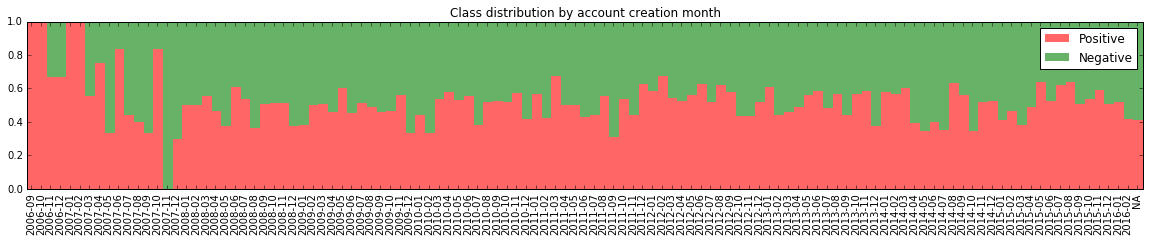

In [11]:
def count_users(grouped):
    """
    Counts number of positive and negative users
    created at each date.
    
    Returns:
        count_pos -- 1D numpy array with the counts of positive users created at each date
        count_neg -- 1D numpy array with the counts of negative users created at each date
        dts -- a list of date strings, e.g. ['2014-10', '2014-11', ...]
    """
    dts = grouped.groups.keys()
    count_pos, count_neg = np.zeros(len(grouped)), np.zeros(len(grouped))
    
    for date_idx in xrange(len(dts)):
        cats = grouped.get_group(dts[date_idx]).groupby('cat')
        if 0.0 in cats.groups:
            count_neg[date_idx] = len(cats.groups[0.0])
        if 1.0 in cats.groups:
            count_pos[date_idx] = len(cats.groups[1.0])

    return count_pos, count_neg, dts


grouped = df_full.groupby(map(lambda dt: dt if pd.notnull(dt) else "NA", df_full["created_at"]))
count_pos, count_neg, dts = count_users(grouped)
    
fraction_pos = count_pos / (count_pos + count_neg + 1e-10)
fraction_neg = 1 - fraction_pos

sort_ind = np.argsort(dts)
    
pl.figure(figsize=(20, 3))
pl.bar(np.arange(len(dts)), fraction_pos[sort_ind], width=1.0, color='red', alpha=0.6, linewidth=0, label="Positive")
pl.bar(np.arange(len(dts)), fraction_neg[sort_ind], bottom=fraction_pos[sort_ind], width=1.0, color='green', alpha=0.6, linewidth=0, label="Negative")
pl.xticks(np.arange(len(dts)) + 0.4, sorted(dts), rotation=90)
pl.title("Class distribution by account creation month")
pl.xlim(0, len(dts))
pl.legend()
pl.show()

Видно, что доля "положительных" аккаунтов в выборке растет с увеличением времени. Посмотрим, где живут пользователи положительной и отрицательной категории. Для этого отметим на карте каждого положительного пользователя красным, а отрицательного -- зеленым цветом ([подсказка](http://anokhin.github.io/img/hw1_map.png)). Необходимо реализовать функцию plot_points_on_map. В функции необходимо отобразить на карте пользователей из разных классов (2 балла).

/Users/vadim/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


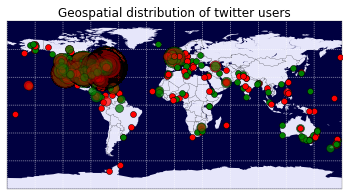

In [12]:
## pl.figure(figsize=(20,12))

m = bm.Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')

m.drawcountries(linewidth=0.2)
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)

def convert(row):
    x, y = m(float(row[0]), float(row[1]))
    return [x, y, row[2]]

def plot_points_on_map(df_full):
    plots = df_full[['lon','lat','cat']].dropna(how='any').apply(convert, axis = 1)
    
    for index, row in plots.iterrows():
        x, y, cat = row
        eps = 0.1
        expr = '(lon < {0}) & (lon > {1}) & (lat < {2}) & (lat > {3}) & (cat == {4})'.format(x+eps, x-eps, y+eps, y-eps, cat)
        #expr2 = '(lon < {0}) & (lon > {1}) & (lat < {2}) & (lat > {3})'.format(x+eps, x-eps, y+eps, y-eps)
        count = len(plots.query(expr))
        #count2 = len(plots.query(expr2))
        radius = 6 * pow(count, 0.4)
        m.plot(y, x, 'o', markersize = radius, color=['g','r'][int(cat)], alpha = 1.0 / count)
    
    return

plot_points_on_map(df_full)

pl.title("Geospatial distribution of twitter users")
pl.legend()
pl.show()

В последней картинке есть проблема: сервис геоинформации определяет координаты с точностью до города, поэтому точки, соответствующте нескольким пользователям, могут накладываться. Предложите и реализуйте способ, позволяющий справиться с этой проблемой (2 балла).

Смотрим на полученный data frame и сохраняем его в .csv файл.

В поле ниже необходимо словами описать, как было улучшено изображение (описание необходимо для корректной проверки задания).

На изображении сделаны следующие улучшения:
* Размер каждой круглой отметки динамический - чем больше пользователей в некоторой eps-окрестности, тем больше круг. eps и коэффициенты в формуле рассчёта радиуса подбирал вручную.
* Все отметки имеют прозрачность 0.5, чтобы происходило "смешивание цветов" в местах пересечений положительных и отрицательных пользователей.

In [13]:
OUT_FILE_PATH = "hw1_out.csv"
print "Saving output data frame to %s" % OUT_FILE_PATH
df_full.to_csv(OUT_FILE_PATH, sep="\t", index=False, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)
df_full.head()

Saving output data frame to hw1_out.csv


,uid,cat,name,screen_name,description,verified,location,lat,lon,country,created_at,followers_count,friends_count,statuses_count,favourites_count,listed_count,country_code
0,40585382,1,Reverend Sue,ReverendSue,Retired Interfaith Minister. Activist. Equalit...,False,United States,-98.5,39.76,United States,2009-05,7604,4282,50614,787,417,NaN
1,30005269,0,Ryan Wrasse,RWrasse,Communications Director for @SenJohnThune | Ge...,False,Capitol Hill,145.75313,15.20825,Northern Mariana Islands,2009-04,1920,1241,7162,127,97,NaN
2,3314758074,0,Campaign Trump,MooreJohnvii,#AlwaysTrump for President. Indp Local & Inter...,False,"Florida, USA",-82.5001,28.75054,United States,2015-08,24912,12404,2305,7807,217,NaN
3,14311688,0,Bernard Whitman,BernardWhitman,"Democratic strategist, pollster, and corporate...",False,New York,-74.00597,40.71427,United States,2008-04,1770,1298,7382,176,110,NaN
4,110457801,0,Carson Ingle,caingle,Writer for @AthleteSpeakers & @NOPACTalent. 10...,False,Orlando aka The City Beautiful,None,None,None,2010-02,1481,1189,37228,3327,76,NaN
